In [ ]:
# Cài đặt Java 11
!apt-get update -qq
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
# Cài đặt PySpark
!pip install -q pyspark
# Thiết lập đường dẫn JAVA_HOME (
import os
java_path = os.popen("readlink -f /usr/bin/java | sed 's:/bin/java::'").read().strip()
os.environ["JAVA_HOME"] = java_path

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion, StandardScaler
from pyspark.sql.functions import col, avg, exp, abs, mean, stddev
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from functools import reduce

#Đọc dữ liệu

In [ ]:
# Khởi tạo Spark Session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("DuBaoGiaNha_KingCounty") \
    .getOrCreate()
print("Phiên bản Spark:", spark.version)

Phiên bản Spark: 4.0.1


In [ ]:
# Đọc dữ liệu
df = spark.read.csv('/content/df_cleaned .csv', header= True, inferSchema= True )
df.show(5)

+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------+--------+----------+-----------+---------+-------------+-----------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_basement|zipcode|    lat|    long|sqft_lot15|  log_price|house_age|was_renovated|   distance|
+--------+---------+-----------+--------+------+----------+----+---------+-----+-------------+-------+-------+--------+----------+-----------+---------+-------------+-----------+
|       6|      3.0|       2400|    9373|   2.0|         0|   0|        3|    7|            0|  98002|47.3262|-122.214|      7316|12.61153775|       24|            0|0.293186508|
|       4|     1.75|       2060|   26036|   1.0|         0|   0|        4|    8|          900|  98166|47.4444|-122.351|     21891|13.38087407|       68|            0|0.206841509|
|       3|      1.0|       1460|   43000|   1.0|         0|   0|        3|    7|            0|  98166|47.

#Phân tích mô tả

In [ ]:
# Thông tin chung
print(f"Số lượng dòng: {df.count()}")
print(f"Số lượng cột: {len(df.columns)}")
df.printSchema()

Số lượng dòng: 21427
Số lượng cột: 18
root
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- house_age: integer (nullable = true)
 |-- was_renovated: integer (nullable = true)
 |-- distance: double (nullable = true)



##Bảng thống kê

In [ ]:
# Chọn các cột quan trọng để thống kê
cols = ['log_price', 'bedrooms','bathrooms','sqft_living','sqft_lot','house_age']
table = dict()
table[''] = ['Min','Max','Mean','Var','Std','Q1','Q2','Q3']
for i in cols:
  s = df.select(
      F.min(i).alias('Min'),
      F.max(i).alias('Max'),
      F.mean(i).alias('Mean'),
      F.variance(i).alias('Var'),
      F.stddev(i).alias('Std'),
      F.expr(f'percentile_approx({i}, array(0.25,0.5,0.75))').alias('Q')
  ).first()
  table[i] = [s['Min'],s['Max'],s['Mean'],s['Var'],s['Std'],s['Q'][0],s['Q'][1],s['Q'][2]]
table = pd.DataFrame(table).set_index('')
table

,log_price,bedrooms,bathrooms,sqft_living,sqft_lot,house_age
,,,,,,
Min,11.225243,0.000000,0.000000,290.000000,5.200000e+02,0.000000
Max,15.856731,11.000000,8.000000,12050.000000,1.651359e+06,115.000000
Mean,13.051621,3.369020,2.115905,2081.654128,1.512474e+04,43.905166
Var,0.274255,0.818312,0.586887,838091.422185,1.722162e+09,863.626402
Std,0.523694,0.904606,0.766086,915.473332,4.149893e+04,29.387521
Q1,12.690041,3.000000,1.750000,1430.000000,5.040000e+03,18.000000
Q2,13.017003,3.000000,2.250000,1920.000000,7.613000e+03,40.000000
Q3,13.377006,4.000000,2.500000,2550.000000,1.069500e+04,63.000000


##Ma trận tương quan

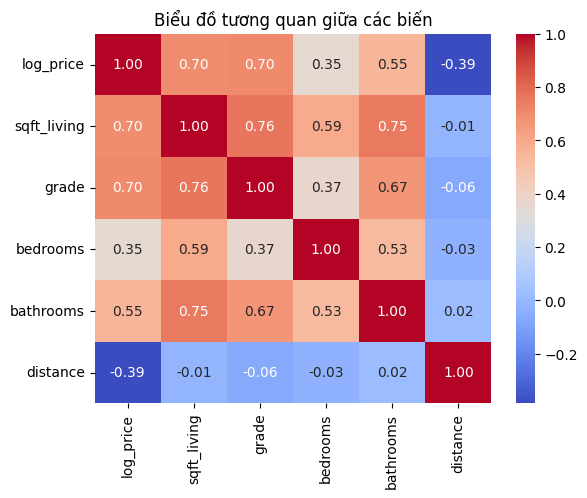

In [ ]:
# Chọn các cột số quan trọng để xem tương quan
numeric_cols = ['log_price', 'sqft_living', 'grade', 'bedrooms', 'bathrooms', 'distance']
# Tạo vector cho các cột này (để tính tương quan)
assembler_corr = VectorAssembler(inputCols=numeric_cols, outputCol="corr_features")
df_corr = assembler_corr.transform(df).select("corr_features")
# Tính ma trận tương quan bằng Spark (Pearson)
matrix = Correlation.corr(df_corr, "corr_features").head()
corr_matrix = matrix[0].toArray()
# Vẽ biểu đồ Heatmap
sns.heatmap(corr_matrix,
            xticklabels=numeric_cols,
            yticklabels=numeric_cols,
            annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Biểu đồ tương quan giữa các biến")
plt.show()

#Phân tích dự báo

##Chia tập dữ liệu

In [ ]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(f"Số lượng tập Train: {train_df.count()}")
print(f"Số lượng tập Test: {test_df.count()}")

Số lượng tập Train: 17197
Số lượng tập Test: 4230


In [ ]:
# Xử lý cột zipcode

# Học từ tập train
# Tính đơn giá tạm thời ppsf = log_price / sqft_living
train_df = train_df.withColumn("ppsf", col("log_price") / col("sqft_living"))

# Tính trung bình ppsf cho từng mã Zipcode
# Tạo ra một bảng "từ điển" giá nhà theo khu vực
zip_stats = train_df.groupBy("zipcode").agg(avg("ppsf").alias("zip_avg_ppsf"))

# áp dụng vào dữ liệu
# Join bảng "từ điển" vào tập Train
train_df = train_df.join(zip_stats, on="zipcode", how="left")

# Join bảng "từ điển" vào tập Test
# Dùng kiến thức học được từ Train để áp dụng cho Test
test_df = test_df.join(zip_stats, on="zipcode", how="left")

# Xóa cột phụ ppsf và cột zipcode
train_df = train_df.drop("ppsf", "zipcode")
test_df = test_df.drop("zipcode")

train_df.select("zip_avg_ppsf", "log_price").show(5)

+--------------------+-----------+
|        zip_avg_ppsf|  log_price|
+--------------------+-----------+
| 0.00753680871832963|11.86358234|
|0.007246231834250503|11.84904049|
|0.005701759629942069|12.36734079|
|0.007046508670009575|12.77987307|
|0.007770499101089387|13.90626492|
+--------------------+-----------+
only showing top 5 rows


##Xây dựng mô hình

In [ ]:
# Danh sách các cột đầu vào (Features)
feature_cols = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'waterfront', 'view', 'condition', 'grade', 'sqft_basement',
    'lat', 'long', 'sqft_lot15', 'house_age',
    'was_renovated', 'distance','zip_avg_ppsf'
]
# Thiết lập pipeline

# 1. Vector Assembler (Gom dữ liệu)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")

# 2. Polynomial Expansion (Tạo đa thức bậc 2)
poly = PolynomialExpansion(degree=2, inputCol="raw_features", outputCol="poly_features")

# 3. Standard Scaler (Chuẩn hóa)
scaler = StandardScaler(inputCol="poly_features", outputCol="features",
                        withStd=True, withMean=True)

# 4. Linear Regression (Cấu hình lại tham số)
lr_tuned = LinearRegression(featuresCol="features", labelCol="log_price",
                            regParam=0.1,
                            elasticNetParam=0.0,
                            solver="normal")
# Tạo Pipeline
pipeline = Pipeline(stages=[assembler, poly, scaler, lr_tuned])

# Huấn luyện mô hình
model = pipeline.fit(train_df)
# Dự báo
predictions = model.transform(test_df)

##Đánh giá mô hình

In [ ]:
# Biến đổi kết quả dự báo về giá trị thực (price)
results = predictions.withColumn("Price_Actual", exp("log_price")) \
                     .withColumn("Price_Pred", exp("prediction"))
# Tính R2 và RMSE (Trên đơn vị Log)
evaluator_r2 = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")
r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
# Tính Adjusted R2 (R2 hiệu chỉnh)
n = predictions.count() # Số lượng mẫu tập Test
p = len(feature_cols)   # Số lượng biến đầu vào
r2_adj = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
# Tính MAE - Sai số tuyệt đối trung bình
mae = results.select(mean(abs(col("Price_Actual") - col("Price_Pred")))).first()[0]
# Tính MAPE - Sai số phần trăm
mape = results.select(mean(abs((col("Price_Actual") - col("Price_Pred")) / col("Price_Actual")))).first()[0] * 100

print(f"R2 Score (Độ chính xác): {r2:.4f}")
print(f"RMSE (Sai số chuẩn):     {rmse:.4f}")
print(f"MAE (Sai số trung bình): ${mae:,.0f}")
print(f"MAPE (Sai số phần trăm): {mape:.2f}%")

R2 Score (Độ chính xác): 0.8068
RMSE (Sai số chuẩn):     0.2304
MAE (Sai số trung bình): $99,204
MAPE (Sai số phần trăm): 18.19%


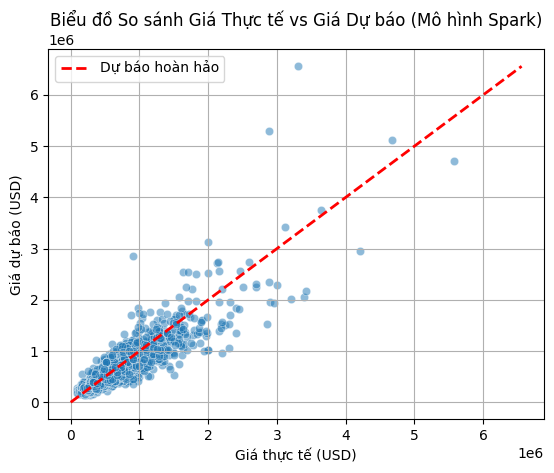

In [ ]:
# Vẽ biểu đồ giá trị dự báo và giá trị thực tế
pdf = results.select("Price_Actual", "Price_Pred").sample(False,1.0, seed=42).toPandas()
sns.scatterplot(x='Price_Actual', y='Price_Pred', data=pdf, alpha=0.5)
# Vẽ đường chéo đỏ (kỳ vọng dự đoán trùng khít thực tế)
m_max = pdf.max().max()
plt.plot([0, m_max], [0, m_max], color='red', linestyle='--', linewidth=2, label='Dự báo hoàn hảo')
plt.xlabel("Giá thực tế (USD)")
plt.ylabel("Giá dự báo (USD)")
plt.title("Biểu đồ So sánh Giá Thực tế vs Giá Dự báo (Mô hình Spark)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Kiểm tra overfitting và underfitting
# Dự báo lại trên tập Train
train_pred = model.transform(train_df)
r2_train = evaluator_r2.evaluate(train_pred)
print(f"R2 trên tập TRAIN: {r2_train:.4f}")
print(f"R2 trên tập TEST:  {r2:.4f}")

R2 trên tập TRAIN: 0.8028
R2 trên tập TEST:  0.8068


In [ ]:
# Kiểm định chéo
# Vector hóa
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_final = assembler.transform(train_df).select("features", "log_price")

# Cài đặt tham số mô hình
lr = LinearRegression(featuresCol="features", labelCol="log_price",
                      solver="normal", elasticNetParam=0.0, regParam=0.0)

# Chia dữ liệu thành 5 phần ngẫu nhiên
folds = train_final.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed=42)
# Danh sách để lưu kết quả từng lần chạy
results_list = []

for i in range(5):
    test_fold = folds[i]
    train_fold_list = [folds[j] for j in range(5) if j != i]
    train_fold = reduce(lambda df1, df2: df1.union(df2), train_fold_list)
    # Huấn luyện mô hình
    model = lr.fit(train_fold)
    # Dự báo
    predictions = model.transform(test_fold)
    # Tính toán chỉ số
    # R2 và RMSE (trên log_price)
    eval_r2 = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2")
    eval_rmse = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")
    r2 = eval_r2.evaluate(predictions)
    rmse = eval_rmse.evaluate(predictions)
    # MAE (trên giá USD thực tế)
    # Chuyển log về giá thật
    pred_real = predictions.withColumn("Price_Real", exp("log_price")) \
                           .withColumn("Price_Pred", exp("prediction"))
    mae = pred_real.select(mean(abs(col("Price_Real") - col("Price_Pred")))).first()[0]
    # Lưu vào danh sách
    results_list.append({
        "Lần chạy (Fold)": f"{i + 1}",
        "R2 Score": r2,
        "RMSE (Log)": rmse,
        "MAE (USD)": mae
    })
#Xuất kết quả ra bảng Pandas
df_results = pd.DataFrame(results_list)
# Tính dòng trung bình (Average)
avg_row = {
    "Lần chạy (Fold)": "Trung bình (Mean)",
    "R2 Score": df_results["R2 Score"].mean(),
    "RMSE (Log)": df_results["RMSE (Log)"].mean(),
    "MAE (USD)": df_results["MAE (USD)"].mean()
}
# Tính Std của cột R2, Std của cột RMSE, Std của cột MAE
std_values = df_results.std(numeric_only=True)
std_row = pd.DataFrame([{
    "Lần chạy (Fold)": "Độ lệch (Std Dev)",
    "R2 Score": std_values["R2 Score"],
    "RMSE (Log)": std_values["RMSE (Log)"],
    "MAE (USD)": std_values["MAE (USD)"]
}])
# Thêm dòng trung bình và std vào cuối bảng
df_results = pd.concat([df_results, pd.DataFrame([avg_row]), std_row], ignore_index=True)
# Hiển thị bảng
df_results.style.format({
    "R2 Score": "{:.4f}",
    "RMSE (Log)": "{:.4f}",
    "MAE (USD)": "{:,.0f}"
}).hide(axis='index')

Lần chạy (Fold),R2 Score,RMSE (Log),MAE (USD)
1,0.7678,0.2493,"107,727"
2,0.7880,0.2382,"101,894"
3,0.7843,0.2468,"107,197"
4,0.7933,0.2399,"103,631"
5,0.7904,0.2396,"103,113"
Trung bình (Mean),0.7848,0.2428,"104,713"
Độ lệch (Std Dev),0.0100,0.0049,"2,595"
